In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# dataset: https://www.kaggle.com/datasets/barkhaverma/student-performance

In [202]:
# Importing and understanding of data.
data_names = ['school', 'sex', 'age', 'address', 'family_size', 'parent_cohabition_status', 'mother_education', 'father_education','mother_job', 'father_job', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'school_support', 'family_support', 'paid', 'extra_curricular_activities', 'nursery', 'higher', 'internet_access', 'romantic', 'famrel', 'freetime', 'going_out', 'workday_alcohol', 'weekend_alcohol', 'health', 'absences', 'grade_period1', 'grade_period2', 'final_grade' ]
data = pd.read_csv('/content/student-por.csv', sep=",")
data.columns = data_names
print(len(data.values))
print(data.dtypes)
data = data.drop_duplicates()
data.head(10)

649
school                         object
sex                            object
age                             int64
address                        object
family_size                    object
parent_cohabition_status       object
mother_education                int64
father_education                int64
mother_job                     object
father_job                     object
reason                         object
guardian                       object
traveltime                      int64
studytime                       int64
failures                        int64
school_support                 object
family_support                 object
paid                           object
extra_curricular_activities    object
nursery                        object
higher                         object
internet_access                object
romantic                       object
famrel                          int64
freetime                        int64
going_out                       int64
workday_

,school,sex,age,address,family_size,parent_cohabition_status,mother_education,father_education,mother_job,father_job,...,famrel,freetime,going_out,workday_alcohol,weekend_alcohol,health,absences,grade_period1,grade_period2,final_grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,6,12,12,13
6,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,13,12,13
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,2,10,13,13
8,GP,M,15,U,LE3,A,3,2,services,other,...,4,2,2,1,1,1,0,15,16,17
9,GP,M,15,U,GT3,T,3,4,other,other,...,5,5,1,1,1,5,0,12,12,13


In [203]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

# the final grade seems to be most negatively correlated with number of failures in past classes and also weekday alcohol consumption
# it seems to be most positively correlated with studytime, mother's education (almost as much as studytime!), but mainly grades from previos periods. 

,age,mother_education,father_education,traveltime,studytime,failures,famrel,freetime,going_out,workday_alcohol,weekend_alcohol,health,absences,grade_period1,grade_period2,final_grade
age,1.00,-0.11,-0.12,0.03,-0.01,0.32,-0.02,-0.00,0.11,0.13,0.09,-0.01,0.15,-0.17,-0.11,-0.11
mother_education,-0.11,1.00,0.65,-0.27,0.10,-0.17,0.02,-0.02,0.01,-0.01,-0.02,0.00,-0.01,0.26,0.26,0.24
father_education,-0.12,0.65,1.00,-0.21,0.05,-0.17,0.02,0.01,0.03,0.00,0.04,0.04,0.03,0.22,0.23,0.21
traveltime,0.03,-0.27,-0.21,1.00,-0.06,0.10,-0.01,0.00,0.06,0.09,0.06,-0.05,-0.01,-0.15,-0.15,-0.13
studytime,-0.01,0.10,0.05,-0.06,1.00,-0.15,-0.00,-0.07,-0.08,-0.14,-0.21,-0.06,-0.12,0.26,0.24,0.25
failures,0.32,-0.17,-0.17,0.10,-0.15,1.00,-0.06,0.11,0.05,0.11,0.08,0.04,0.12,-0.38,-0.39,-0.39
famrel,-0.02,0.02,0.02,-0.01,-0.00,-0.06,1.00,0.13,0.09,-0.08,-0.09,0.11,-0.09,0.05,0.09,0.06
freetime,-0.00,-0.02,0.01,0.00,-0.07,0.11,0.13,1.00,0.35,0.11,0.12,0.08,-0.02,-0.09,-0.11,-0.12
going_out,0.11,0.01,0.03,0.06,-0.08,0.05,0.09,0.35,1.00,0.25,0.39,-0.02,0.09,-0.07,-0.08,-0.09
workday_alcohol,0.13,-0.01,0.00,0.09,-0.14,0.11,-0.08,0.11,0.25,1.00,0.62,0.06,0.17,-0.20,-0.19,-0.20


In [214]:
# We can see that the final grade is highly correlated with grades in other period.
# Since these are very simular, we remove these columns too not get overly optimistic results on the algorithm. 
data = data.drop(['grade_period1', 'grade_period2'], axis=1)

In [205]:
data=data.replace(r'^\s*$', np.nan, regex=True)   # transform all whitespaces to NaNs.
print(data.isnull().values.any())    # checking so there isn't any NaNs in the data.

False


In [206]:
numerical_columns = ['age', 'mother_education', 'father_education', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'going_out', 'workday_alcohol', 'weekend_alcohol', 'health', 'absences', 'final_grade']
# there are 14 numerical attributes.  

In [216]:
# Get the dummies so that it is easier to work. 
# This is, transform the categorical columns into numerical ones.

# categorical_columns = data.select_dtypes('object')
categorical_columns = ['school', 'sex', 'family_size', 'parent_cohabition_status', 'mother_job', 'father_job', 'reason', 'guardian', 'school_support', 'family_support', 'paid', 'extra_curricular_activities', 'nursery', 'higher', 'internet_access', 'romantic']

data = pd.get_dummies(data, drop_first=True)
data.columns
data.describe()

# Transform the data. 
# we need to standarize the data to take into consideration variations in measurments, units and scales. 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numerical_columns])
scaled_dataframe = pd.DataFrame(scaled_data, columns = numerical_columns)  
print(scaled_dataframe.columns)
scaled_dataframe.head()

for column in numerical_columns:
  data.append(scaled_dataframe[column])
  data[column] = scaled_dataframe[column]

data
     

Index(['age', 'mother_education', 'father_education', 'traveltime',
       'studytime', 'failures', 'famrel', 'freetime', 'going_out',
       'workday_alcohol', 'weekend_alcohol', 'health', 'absences',
       'final_grade'],
      dtype='object')


,age,mother_education,father_education,traveltime,studytime,failures,famrel,freetime,going_out,workday_alcohol,...,guardian_mother,guardian_other,school_support_yes,family_support_yes,paid_yes,extra_curricular_activities_yes,nursery_yes,higher_yes,internet_access_yes,romantic_yes
0,1.031695,1.310216,1.540715,0.576718,0.083653,-0.374305,0.072606,-0.171647,0.693785,-0.543555,...,1,0,1,0,0,0,1,1,0,0
1,0.210137,-1.336039,-1.188832,-0.760032,0.083653,-0.374305,1.119748,-0.171647,-0.157380,-0.543555,...,0,0,0,1,0,0,0,1,1,0
2,-1.432980,-1.336039,-1.188832,-0.760032,0.083653,-0.374305,0.072606,-0.171647,-1.008546,0.538553,...,1,0,1,0,0,0,1,1,1,0
3,-1.432980,1.310216,-0.278983,-0.760032,1.290114,-0.374305,-0.974536,-1.123771,-1.008546,-0.543555,...,1,0,0,1,0,1,1,1,1,1
4,-0.611422,0.428131,0.630866,-0.760032,0.083653,-0.374305,0.072606,-0.171647,-1.008546,-0.543555,...,0,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,1.853254,-0.453954,0.630866,-0.760032,1.290114,1.312667,1.119748,0.780478,-1.008546,-0.543555,...,1,0,0,0,0,1,0,1,1,0
645,1.031695,0.428131,-1.188832,-0.760032,0.083653,-0.374305,0.072606,-0.171647,0.693785,-0.543555,...,1,0,0,1,0,0,1,1,1,0
646,1.031695,-1.336039,-1.188832,0.576718,0.083653,-0.374305,-3.068820,-2.075896,-1.859711,-0.543555,...,1,0,0,0,0,1,1,1,0,0
647,0.210137,0.428131,-1.188832,0.576718,-1.122808,-0.374305,-2.021678,0.780478,1.544950,1.620662,...,1,0,0,0,0,0,0,1,1,0


In [215]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,age,mother_education,father_education,traveltime,studytime,failures,famrel,freetime,going_out,workday_alcohol,weekend_alcohol,health,absences,final_grade,school_MS,sex_M,address_U,family_size_LE3,parent_cohabition_status_T,mother_job_health,mother_job_other,mother_job_services,mother_job_teacher,father_job_health,father_job_other,father_job_services,father_job_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,school_support_yes,family_support_yes,paid_yes,extra_curricular_activities_yes,nursery_yes,higher_yes,internet_access_yes,romantic_yes
age,1.00,-0.11,-0.12,0.03,-0.01,0.32,-0.02,-0.00,0.11,0.13,0.09,-0.01,0.15,-0.11,0.09,-0.04,-0.03,-0.00,-0.01,-0.10,0.04,-0.03,-0.05,-0.10,0.06,-0.02,-0.05,-0.01,-0.01,-0.02,-0.05,0.33,-0.17,-0.10,-0.01,-0.05,-0.02,-0.27,0.01,0.18
mother_education,-0.11,1.00,0.65,-0.27,0.10,-0.17,0.02,-0.02,0.01,-0.01,-0.02,0.00,-0.01,0.24,-0.25,0.12,0.19,-0.01,-0.06,0.26,-0.22,0.13,0.45,0.16,-0.12,-0.01,0.26,0.04,-0.03,0.13,0.09,-0.10,-0.02,0.12,0.11,0.12,0.13,0.21,0.27,-0.03
father_education,-0.12,0.65,1.00,-0.21,0.05,-0.17,0.02,0.01,0.03,0.00,0.04,0.04,0.03,0.21,-0.21,0.08,0.14,-0.04,-0.03,0.14,-0.20,0.10,0.31,0.23,-0.22,0.03,0.35,0.02,-0.03,0.09,-0.04,-0.07,0.02,0.14,0.09,0.08,0.07,0.19,0.18,-0.07
traveltime,0.03,-0.27,-0.21,1.00,-0.06,0.10,-0.01,0.00,0.06,0.09,0.06,-0.05,-0.01,-0.13,0.25,0.04,-0.34,0.01,0.04,-0.10,0.03,-0.07,-0.10,-0.09,0.10,-0.03,-0.04,-0.13,0.06,-0.08,-0.07,0.09,-0.04,-0.04,-0.04,-0.03,-0.01,-0.07,-0.19,0.00
studytime,-0.01,0.10,0.05,-0.06,1.00,-0.15,-0.00,-0.07,-0.08,-0.14,-0.21,-0.06,-0.12,0.25,-0.14,-0.21,0.06,-0.01,-0.01,-0.02,-0.00,0.03,0.04,0.10,-0.04,0.01,-0.02,-0.01,-0.09,0.18,-0.02,0.01,0.09,0.14,-0.00,0.07,0.04,0.19,0.04,0.03
failures,0.32,-0.17,-0.17,0.10,-0.15,1.00,-0.06,0.11,0.05,0.11,0.08,0.04,0.12,-0.39,0.11,0.07,-0.06,-0.07,-0.01,-0.02,-0.00,0.01,-0.12,-0.06,0.04,-0.01,-0.08,-0.08,0.00,-0.11,-0.06,0.23,-0.00,-0.01,0.07,0.00,-0.07,-0.31,-0.10,0.07
famrel,-0.02,0.02,0.02,-0.01,-0.00,-0.06,1.00,0.13,0.09,-0.08,-0.09,0.11,-0.09,0.06,-0.03,0.08,-0.03,0.00,0.05,-0.03,-0.01,0.04,-0.00,0.01,0.02,0.04,-0.05,-0.02,0.02,0.03,0.01,-0.07,-0.01,0.02,0.03,0.06,0.04,0.05,0.08,-0.04
freetime,-0.00,-0.02,0.01,0.00,-0.07,0.11,0.13,1.00,0.35,0.11,0.12,0.08,-0.02,-0.12,0.03,0.15,-0.04,-0.02,0.04,-0.02,-0.02,0.01,0.06,-0.02,0.04,-0.05,0.00,-0.06,-0.03,-0.01,0.02,0.03,-0.02,0.00,-0.05,0.15,-0.01,-0.10,0.06,0.03
going_out,0.11,0.01,0.03,0.06,-0.08,0.05,0.09,0.35,1.00,0.25,0.39,-0.02,0.09,-0.09,0.04,0.06,0.02,-0.00,0.03,0.04,0.01,0.04,-0.06,0.03,0.04,-0.03,-0.04,-0.01,0.00,-0.00,0.04,0.02,-0.06,0.02,-0.01,0.09,0.02,-0.07,0.09,-0.00
workday_alcohol,0.13,-0.01,0.00,0.09,-0.14,0.11,-0.08,0.11,0.25,1.00,0.62,0.06,0.17,-0.20,0.05,0.28,-0.05,0.06,0.04,-0.08,-0.02,0.06,0.03,-0.00,-0.05,0.09,-0.02,0.06,0.12,-0.09,-0.09,0.11,-0.03,-0.02,0.05,0.02,-0.08,-0.13,0.04,0.06


In [217]:
# Lasso Regression is a popular type of regularized linear regression that includes an L1 penalty.
# This penalty allows some coefficient values to go to the value of zero, allowing input variables to be effectively removed from the model, providing a type of automatic feature selection.

X_encoded = data.drop("final_grade", axis=1)
y_encoded = data["final_grade"]

X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=1) 

# We will also divide into a validation set to choose models based on
X_train_encoded, X_val, y_train_encoded, y_val = train_test_split(X_train_encoded, y_train_encoded, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2 


lasso_model_total = Lasso(alpha = 0.1)  # A LASSO model with all the features

lasso_model_total.fit(X_train_encoded, y_train_encoded)
yhat_tot_lasso = lasso_model_total.predict(X_val)    # the prediction
print(yhat_tot_lasso)

[ 0.08638119  0.08638119 -0.10612936  0.10031392  0.30959783  0.0685911
  0.33670778  0.17302064 -0.27120995 -0.31541327  0.25510601  0.3551946
  0.08638119 -0.4476495   0.16342887  0.20902564  0.17302064  0.21792069
  0.1646092   0.30959783  0.11467147 -0.31611     0.4272046  -0.31611
 -0.04081735  0.3316701   0.3191896   0.3013995  -0.09530916  0.30070278
  0.28248787 -1.26152691  0.08686479  0.09527624  0.1646092   0.10417128
  0.03119265 -0.25272313  0.12742387 -0.4476495   0.0690747   0.16846656
 -0.45724126  0.19081074  0.10031392  0.15480574 -0.22443286  0.10465488
  0.3551946   0.13701564  0.01844024 -0.0319223   0.28221597  0.16916328
  0.34629955  0.01367447  0.17302064 -0.42096436  0.05857451  0.11011738
  0.14612238  0.08568447  0.19081074  0.09141887 -0.64519773  0.21020597
  0.2596601   0.2596601   0.11397474  0.12286979  0.12238619  0.15957151
  0.22681574  0.3911996   0.04582211  0.2596601  -0.77309299  0.1050797
  0.06816628  0.25006833 -0.44330853  0.17302064  0.28291

In [218]:
# Let's evaluate how well the model did

mse_tot = mean_squared_error(y_val, yhat_tot_lasso)   

print("Mean squared error on test set: %.10f" % mse_tot)

rmse_tot = mean_squared_error(y_val, yhat_tot_lasso, squared = False)  

print("Root mean squared error on test set: %.10f" % rmse_tot)  # RMSE measures the average difference between values predicted by a model and the actual values.
# The lower the RMSE, the better a given model is able to “fit” a dataset.

r2_tot_score = r2_score(y_val, yhat_tot_lasso)   # Coefficient of determination. Best possible r2 score is 1.0
print("R^2 score on the test set_ %.10f" % r2_tot_score)

cross_val = cross_val_score(lasso_model_total, X_val, y_val, cv=10,scoring=None, error_score = "raise").mean()
print("Cross-validation accuracy score:", cross_val) 
# The resulting cross-validation score is the average accuracy of the model across all 10 folds.


Mean squared error on test set: 0.8727704322
Root mean squared error on test set: 0.9342218324
R^2 score on the test set_ 0.1334299392
Cross-validation accuracy score: 0.16267629415558083


39


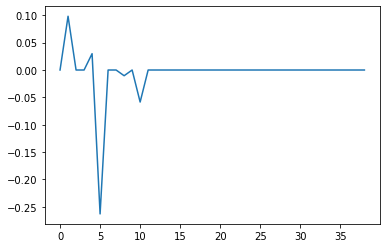


These features are chosen:

['mother_education', 'studytime', 'failures', 'going_out', 'weekend_alcohol']

These features will be removed:

['age', 'father_education', 'traveltime', 'famrel', 'freetime', 'workday_alcohol', 'health', 'absences', 'final_grade', 'school_MS', 'sex_M', 'address_U', 'family_size_LE3', 'parent_cohabition_status_T', 'mother_job_health', 'mother_job_other', 'mother_job_services', 'mother_job_teacher', 'father_job_health', 'father_job_other', 'father_job_services', 'father_job_teacher', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother', 'guardian_other', 'school_support_yes', 'family_support_yes', 'paid_yes', 'extra_curricular_activities_yes', 'nursery_yes', 'higher_yes', 'internet_access_yes']


In [219]:
coefficients = lasso_model_total.coef_
print(len(coefficients))
plt.plot(range(len(coefficients)), coefficients)
plt.show()
chosen_features = []
removed_features = []

for i in range(len(coefficients)):
    if coefficients[i] != 0:
        # print(preprocessed_data.iloc[i])
        chosen_features.append(data.columns[i])
    else:
        removed_features.append(data.columns[i])

print('\n' + 'These features are chosen:' + '\n')
print(chosen_features)

print('\n' + 'These features will be removed:' + '\n')
print(removed_features)

In [220]:
X_sel = data[chosen_features]
y_sel = data["final_grade"]

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, test_size=0.2, random_state=1) 

X_train_sel, X_val_sel, y_train_sel, y_val_sel = train_test_split(X_train_sel, y_train_sel, test_size=0.25, random_state=1)

lasso_model_selected = Lasso(alpha=0.1) 

lasso_model_selected.fit(X_train_sel, y_train_sel)
yhat_from_selection = lasso_model_selected.predict(X_val_sel)    # the prediction
print(yhat_from_selection)

[ 0.08638128  0.08638128 -0.10612905  0.10031359  0.30959748  0.0685917
  0.33670774  0.1730207  -0.27121014 -0.31541295  0.25510583  0.35519434
  0.08638128 -0.44764923  0.16342889  0.20902575  0.1730207   0.21792054
  0.16460914  0.30959748  0.11467178 -0.31610997  0.42720443 -0.31610997
 -0.04081749  0.33167022  0.3191893   0.30139971 -0.09530914  0.30070269
  0.28248723 -1.26152652  0.0868645   0.09527607  0.16460914  0.10417086
  0.0311926  -0.25272353  0.12742384 -0.44764923  0.06907492  0.16846641
 -0.45724105  0.19081028  0.10031359  0.15480524 -0.22443303  0.10465408
  0.35519434  0.13701566  0.01844054 -0.0319227   0.28221609  0.16916343
  0.34629955  0.01367416  0.1730207  -0.42096486  0.058574    0.11011749
  0.14612253  0.08568425  0.19081028  0.0914188  -0.64519708  0.210206
  0.25966013  0.25966013  0.11397476  0.12286955  0.12238632  0.15957162
  0.22681533  0.39119939  0.04582194  0.25966013 -0.77309287  0.10507997
  0.06816581  0.25006831 -0.44330874  0.1730207   0.28

In [221]:
# Let's evaluate how well the model did again

mse_tot = mean_squared_error(y_val_sel, yhat_from_selection)   

print("Mean squared error on test set: %.10f" % mse_tot)

rmse_tot = mean_squared_error(y_val_sel, yhat_from_selection, squared = False)  

print("Root mean squared error on test set: %.10f" % rmse_tot)  # RMSE measures the average difference between values predicted by a model and the actual values.
# The lower the RMSE, the better a given model is able to “fit” a dataset.

r2_tot_score = r2_score(y_val_sel, yhat_from_selection)   # Coefficient of determination. Best possible r2 score is 1.0
print("R^2 score on the test set_ %.10f" % r2_tot_score)

cross_val = cross_val_score(lasso_model_selected, X_val_sel, y_val_sel, cv=10,scoring=None, error_score = "raise").mean()
print("Cross-validation accuracy score:", cross_val)
# The resulting cross-validation score is the average accuracy of the model across all 10 folds.

Mean squared error on test set: 0.8727703333
Root mean squared error on test set: 0.9342217795
R^2 score on the test set_ 0.1334300373
Cross-validation accuracy score: 0.14977577413634938
